In [1]:
# load modules
import os
import sys
import gzip
import numpy as np
# import scipy.stats as stats
import pandas as pd
import pickle
# import bhtsne this doesnt work on my VM for some reason (or computer or anywhere)
import anndata
import scanpy
import scipy #make sure to pip install scipy==1.5.1, seems to be errors with the new one
import phenograph # install from https://github.com/jacoblevine/PhenoGraph
import collections
from scipy.io import mmread,mminfo
from sklearn.manifold import TSNE
from collections import OrderedDict
# Plotting imports
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, NMF
from google.cloud import storage
import umap

from sklearn.mixture import GaussianMixture,BayesianGaussianMixture
import itertools
from scipy import linalg
import pickle
from sklearn.neighbors import kneighbors_graph


import random
##function to generate random colors for coloring clusters
def random_colors(n): #n is the number of colors you need to generate
    color_set = np.zeros((n,3))
    for i in range(n):
        r = random.uniform(0, 1)
        b = random.uniform(0, 1)
        g = random.uniform(0, 1)
        color_set[i] = [r,b,g]
    return color_set

In [2]:
def graph_patients(df_list, names_list, xrange=None):
    fig = plt.figure(figsize=[4 * len(df_list), 4])
    for i, sample in enumerate(df_list):
        ms = np.log10(sample.sum(axis=1)) #library size
        # Figure
        ax = fig.add_subplot(1, len(df_list), i+1)
        ax.hist(ms,50,xrange)
        ax.set_title(names_list[i])
        ax.set_xlabel('log10 of library size')
def cell_filter(threshold, sample):
    ms = sample.sum(axis = 1) #library size 
    use_cells = ms.index[np.log10(ms) > threshold]
    sample = sample.loc[use_cells]
    print(sample.shape)
    return sample

# def gene_filter(sample,threshold=0):
#     before = sample.shape[1]
#     use_genes = sample.columns[sample.sum(axis=0) > threshold]
#     sample = sample[use_genes]
#     print(before - sample.shape[1] , "genes removed")
#     return sample

# loading in patient data

In [6]:
bucket_name = "visiumjuly2020"

storage_client = storage.Client()
bucket = storage_client.get_bucket(bucket_name)

# When you have your files in a subfolder of the bucket.
my_prefix = "10778/MICHELLE_0212_AHJTWTDRXX__Project_10778__Sample_Patient2A_021120_IGO_10778_3/outs/filtered_feature_bc_matrix/" # the name of the subfolder
blobs = bucket.list_blobs(prefix = my_prefix, delimiter = '/')

barcodes_2A = pd.DataFrame()
features_2A = pd.DataFrame()


for blob in blobs:
    if(blob.name != my_prefix): # ignoring the subfolder itself 
        file_name = blob.name.replace(my_prefix, "")
        blob.download_to_filename(file_name) # download the file to the machine
        if "barcodes" in str(file_name):
            df = pd.read_csv(file_name, header=None) # load the data
            barcodes_2A = df
        elif "features" in str(file_name):
            df = pd.read_csv(file_name, sep='\t',names=['geneID','gene_name','type']) # load the data
            features_2A = df
        elif "matrix" in str(file_name):
            matrix_2A = mmread(file_name)

my_prefix = "10778/MICHELLE_0212_AHJTWTDRXX__Project_10778__Sample_Patient2B_021120_IGO_10778_4/outs/filtered_feature_bc_matrix/" # the name of the subfolder
blobs = bucket.list_blobs(prefix = my_prefix, delimiter = '/')

barcodes_2B = pd.DataFrame()
features_2B = pd.DataFrame()


for blob in blobs:
    if(blob.name != my_prefix): # ignoring the subfolder itself 
        file_name = blob.name.replace(my_prefix, "")
        blob.download_to_filename(file_name) # download the file to the machine
        if "barcodes" in str(file_name):
            df = pd.read_csv(file_name, header=None) # load the data
            barcodes_2B = df
        elif "features" in str(file_name):
            df = pd.read_csv(file_name, sep='\t',names=['geneID','gene_name','type']) # load the data
            features_2B = df
        elif "matrix" in str(file_name):
            matrix_2B = mmread(file_name)

                        
            

# process data 

In [7]:
#transposing matrix to cellsxgenes
matrix_2A_transpose = matrix_2A.transpose()
#creating anndata object 
ad_2A = anndata.AnnData(X=matrix_2A_transpose,obs=barcodes_2A,var=features_2A)
#creating dataframe
matrix_2A_transpose_dense=matrix_2A_transpose.todense()
df_2A = pd.DataFrame(matrix_2A_transpose_dense,columns=[x for x in features_2A['gene_name']])
barcodes_df_2A=barcodes_2A.join(df_2A)
df_2A.index = [f'A_{i}' for i in df_2A.index]

/home/cyp2111/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [8]:
#transposing matrix to cellsxgenes
matrix_2B_transpose = matrix_2B.transpose()
#creating anndata object 
ad_2B = anndata.AnnData(X=matrix_2B_transpose,obs=barcodes_2B,var=features_2B)
#creating dataframe
matrix_2B_transpose_dense=matrix_2B_transpose.todense()
df_2B = pd.DataFrame(matrix_2B_transpose_dense,columns=[x for x in features_2B['gene_name']])
barcodes_df_2B=barcodes_2B.join(df_2B)
df_2B.index = [f'B_{i}' for i in df_2B.index]

/home/cyp2111/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


# FILTERING 

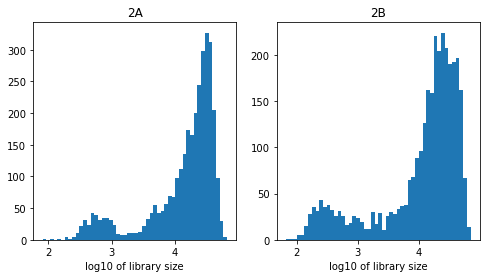

In [11]:
names = ['2A','2B']
dataframes = [df_2A,df_2B]
graph_patients(dataframes,names)

In [12]:
df_2A = cell_filter(3,df_2A)
df_2B = cell_filter(3,df_2B)

(2938, 33538)
(2770, 33538)


In [13]:
df2 = pd.concat([df_2A,df_2B])

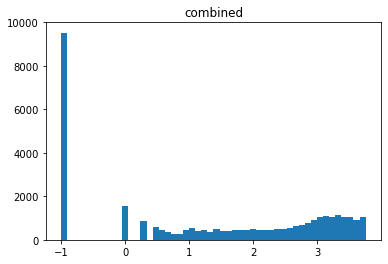

In [14]:
#get the count matrix for each sample set
binary = pd.DataFrame(df2)
binary = np.sign(binary)
binary.sum(axis=0) #sum number of cells a gene is expressed in
ms = np.log10(binary.sum(axis=0) + 0.1) #pseudo count and median lib size happens after 
# ms = counts.sum(axis=1)
# Figure
#create figures for each dataset 
plt.figure()
plt.hist(ms, bins=50)
plt.title("combined")  
plt.show()

In [15]:
##Getting rid of noisy genes
# Counts
THRESHOLD = 1
counts = df2
binary = pd.DataFrame(counts)
binary = np.sign(binary)

# Genes passing the threshold
ms =np.log10(binary.sum(axis = 0) + 0.1)
use_genes = ms.index[ms >= THRESHOLD]

# Update counts
df2 = counts.loc[:, use_genes]

# NORMALIZE AND PCA

In [11]:
ms = df2.sum(axis=1) #library size
norm_df = df2.div(ms, axis=0).mul(np.median(ms), axis=0)
log_norm_df = np.log(0.1+ norm_df)

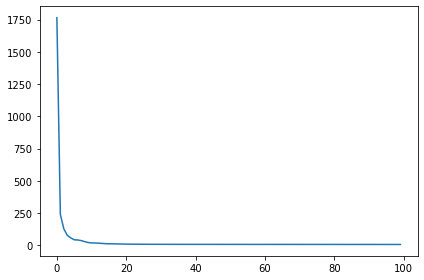

In [12]:
# PCA
no_eigs = 100
pca = PCA(n_components=no_eigs)
pca.fit(log_norm_df.values)
# Get Eiganvectors
eig_vectors = pca.components_
# Get Eiganvalues
eig_values = pca.explained_variance_
plt.plot(eig_values)
plt.tight_layout()

In [13]:
pca= PCA(n_components=20)
pca_projections = pd.DataFrame(pca.fit_transform(log_norm_df),
                index=log_norm_df.index)

In [14]:
tsne_output = TSNE(n_components=2, perplexity = 30).fit_transform(pca_projections)
tsne = pd.DataFrame(tsne_output, index=pca_projections.index, columns=['x', 'y'])

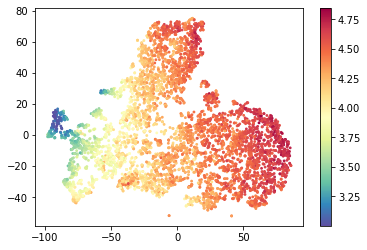

In [15]:
plt.scatter(tsne['x'], tsne['y'], s=8,edgecolors='none', cmap=matplotlib.cm.Spectral_r, c=np.log10(ms +0.1))
plt.colorbar()

In [16]:
umap_data = umap.UMAP()
results = umap_data.fit_transform(pca_projections);
umap_ = pd.DataFrame(results, index=pca_projections.index, columns=['x', 'y'])
plt.scatter(results[:, 0],results[:, 1],s=3,edgecolors='none', cmap=matplotlib.cm.Spectral_r, c=np.log10(ms+0.1))
plt.colorbar()

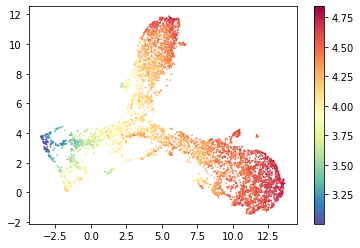

In [17]:
plt.scatter(results[:, 0],results[:, 1],s=3,edgecolors='none', cmap=matplotlib.cm.Spectral_r, c=np.log10(ms+0.1))
plt.colorbar()

# CLUSTERING

In [18]:
knn = kneighbors_graph(pca_projections,n_neighbors = 30, mode='distance', metric = 'manhattan', include_self = True)
communities, graph, Q = phenograph.cluster(knn)

Using neighbor information from provided graph, rather than computing neighbors directly
Jaccard graph constructed in 1.6075096130371094 seconds
Wrote graph to binary file in 0.5107336044311523 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.801512
After 12 runs, maximum modularity is Q = 0.803053
Louvain completed 32 runs in 5.050669193267822 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 8.538570404052734 seconds


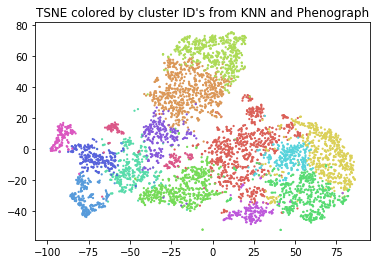

In [19]:
ID =["ID"]
n_cluster_knn = np.amax(communities)
cluster_ID_knn = pd.DataFrame(communities, index = pca_projections.index, columns = ID)
color_set = pd.Series(list(sns.color_palette('hls', n_cluster_knn)))
num_in_cluster = np.zeros(n_cluster_knn)
i=0
for cluster in range(n_cluster_knn):
    bool_array = cluster_ID_knn.ID == cluster
    cells = tsne.index[bool_array]
    num_in_cluster[i] = len(cells)
    plt.scatter(tsne.loc[cells, 'x'], tsne.loc[cells, 'y'],
        s=5, edgecolors='none', color=color_set[cluster])
    i +=1
plt.title("TSNE colored by cluster ID's from KNN and Phenograph")
plt.show()

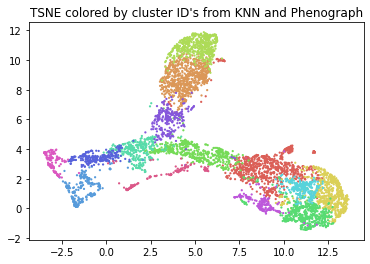

In [20]:
ID =["ID"]
n_cluster_knn = np.amax(communities)
cluster_ID_knn = pd.DataFrame(communities, index = pca_projections.index, columns = ID)
color_set = pd.Series(list(sns.color_palette('hls', n_cluster_knn)))
num_in_cluster = np.zeros(n_cluster_knn)
i=0
for cluster in range(n_cluster_knn):
    bool_array = cluster_ID_knn.ID == cluster
    cells = umap_.index[bool_array]
    num_in_cluster[i] = len(cells)
    plt.scatter(umap_.loc[cells, 'x'], umap_.loc[cells, 'y'],
        s=5, edgecolors='none', color=color_set[cluster])
    i +=1
plt.title("TSNE colored by cluster ID's from KNN and Phenograph")
plt.show()

In [ ]:
# label graph with cluster numbers 

In [22]:
# tsne.to_pickle("./tsne.pkl")
# umap_.to_pickle("./umap.pkl")
# df2.to_pickle("./df2.pkl")
# pca_projections.to_pickle("./pca_projections.pkl")
# log_norm_df.to_pickle("./log_norm_df.pkl")
# cluster_ID_knn.to_pickle("./cluster_ID.pkl")

# NMF 

In [3]:
tsne = pd.read_pickle("./tsne.pkl")
umap_ = pd.read_pickle("./umap.pkl")
df2 = pd.read_pickle("./df2.pkl")
pca_projections = pd.read_pickle("./pca_projections.pkl")
log_norm_df = pd.read_pickle("./log_norm_df.pkl")
cluster_ID = pd.read_pickle("./cluster_ID.pkl")
communities = cluster_ID["ID"]
n_cluster_knn = np.amax(communities)
df = pd.DataFrame(np.array(communities), columns= ["cluster" ], index = df2.index)
df["index"] = np.arange(len(df))
#how to load weights
# loaded_arr = np.loadtxt("weights.txt") 
# load_original_arr = loaded_arr.reshape(1,n_components, len(df2))

#### LIST OF ALL FILES THAT HAVE BEEN PICKLED FROM NMF
##### 10 components with L1 regularizer: 
H_10comp_L1.pkl \\
W_10comp_L1.pkl \\
W_norm_10comp_L1.pkl

##### 20 components with L1 regularizer:
H_20comp_L1.csv
W_20comp_L1.csv
W_norm_20comp_L1.csv

##### 25 components with L1 regularizer:
H_25components_L1.pkl \\
weights_25comp_L1.csv \\
norm_weights_25comp_L1.csv


In [4]:
H = pd.read_csv('./H_20comp_L1.csv')

In [154]:
# n_components = 20
# W_load = np.loadtxt("W_10comp_L1.csv")
# W = W_load.reshape(1,n_components, len(df2))
# W_load = np.loadtxt("W_norm_20comp_L1.csv")
# W_norm = W_load.reshape(1,n_components, len(df2))

In [7]:
#functions for NMF model 
#function takes in a specific cluster and outputs an array with the indicies of all spots assigned to that cluster
def cluster_index(cluster, df):
    a = df.loc[df["cluster"] == cluster]
    array = np.array(a["index"])
    return array
#function runs NMF for specified components and initialization parameters (use raw count matrix)
#use l1_ratio=1 for L1 regularizer, and init='nndsvd' for sparsity
def nmf_function(n_components, init, l1_ratio, df2):
    # fit model on all data (count matrices)
    model = NMF(n_components=n_components, init = init,l1_ratio = l1_ratio, max_iter=10000)
    nmf = model.fit(df2)
    H = nmf.components_
    H = pd.DataFrame(H, columns = df2.columns)
    # now transform each spot 
    W = np.zeros((1,n_components, len(df2)))
    for spot in range(len(df2)):
        spot_array = np.array(df2.iloc[spot]).reshape(1, -1)
        W[:,:,spot] = nmf.transform(spot_array)
    W_norm = np.zeros((1,n_components, len(df2)))
    for spot in range(len(df2)):
        norm = np.sum(W[:,:,spot])
        W_norm[:,:,spot] = W[:,:,spot]/norm
    return H,W,W_norm

def save(H,W,W_norm,name1, name2, name3):
    H.to_csv(name1)
    W_reshape = W.reshape(W.shape[0], -1) 
    np.savetxt(name2, W_reshape) 
    W_reshape_norm = W_norm.reshape(W_norm.shape[0], -1) 
    np.savetxt(name3, W_reshape_norm) 
    return

# getting the weights for all spots in each cluster

def spot_weights_by_cluster(n_components,communities, df, W_norm):
    n_cluster_knn = np.amax(communities)
    sum_test = 0
    for cluster in range(n_cluster_knn + 1):
        #gives the indices for all cells in that cluster
        arr = cluster_index(cluster, df)
        sum_test += len(arr)
        cluster_arr = np.zeros((1,n_components,len(arr)))
        i = 0
        for spot in range(len(df2)):
            if spot not in arr:
                continue
            elif spot in arr:
                cluster_arr[:,:,i] = W_norm[:,:,spot]
                i += 1
        cluster_dict[cluster] = cluster_arr
        ## may need to renormalize components
    return cluster_dict

#getting average weights for each cluster 
def avg_weights_by_cluster(n_components,communities, cluster_dict):
    n_cluster_knn = np.amax(communities)
    for cluster in range(n_cluster_knn + 1):
        cluster_W = cluster_dict[cluster]
        arr = np.zeros((1,n_components))
        for i in range(n_components):
            arr[:,i] = np.mean(cluster_W[:,i,:])
        norm = np.sum(arr)
        if norm==0:
            print("cluster ",cluster)
            print(arr)
            avg_dict[cluster] = arr
            continue
        arr = arr/norm
        if np.sum(arr) > 1.1 or np.sum(arr) < 0.9:
            print("not normalized properly")
        avg_dict[cluster] = arr
    return avg_dict

#filtering to decrease number of graphed components
def filter_components(threshold, n_components,communities, dictionary):
    n_cluster_knn = np.amax(communities)
    for cluster in range(n_cluster_knn + 1):
        a = dictionary[cluster].flatten()
        for i in range(n_components):
            if a[i]<threshold:
                a[i] = 0
        norm = np.sum(a)
        if norm==0:
            print("cluster ",cluster)
            print(a)
            filt_dict[cluster] = a
            continue
        a = a/norm
        filt_dict[cluster] = a
    return filt_dict

In [6]:
# W_norm = np.zeros((1,n_components, len(df2)))
# for spot in range(len(df2)):
#     norm = np.sum(W10[:,:,spot])
#     W_norm[:,:,spot] = W10[:,:,spot]/norm

NameError: name 'W10' is not defined

In [8]:
n_components = 10
H,W,W_norm = nmf_function(n_components,'nndsvd',1,df2)
save(H,W,W_norm, "./H_10comp_L1.csv","./W_10comp_L1.csv","./W_norm_10comp_L1.csv")

cluster_dict = OrderedDict()
cluster_dict = spot_weights_by_cluster(n_components,communities, df, W_norm)
clust_dict = cluster_dict.copy()

avg_dict=OrderedDict()
avg_dict = avg_weights_by_cluster(n_components,communities, clust_dict)
test_dict = avg_dict.copy()

filt_dict = OrderedDict()
filt_dict = filter_components(0.1, n_components, communities, test_dict)

# cluster- level analysis

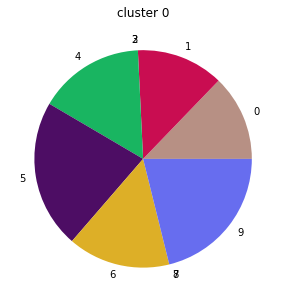

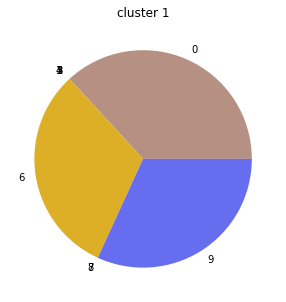

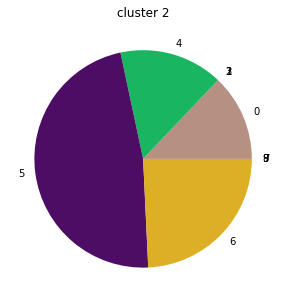

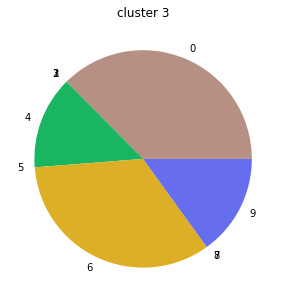

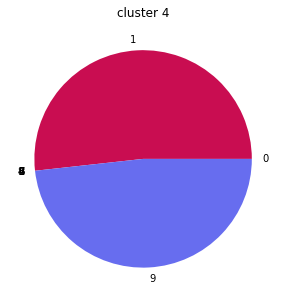

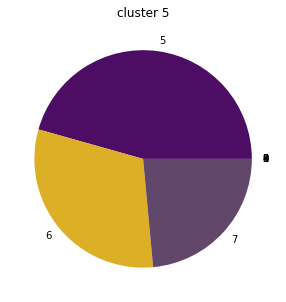

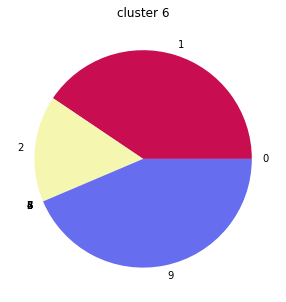

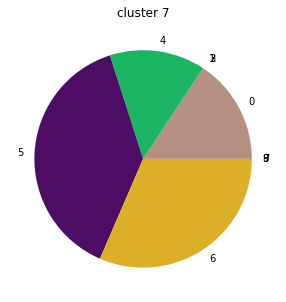

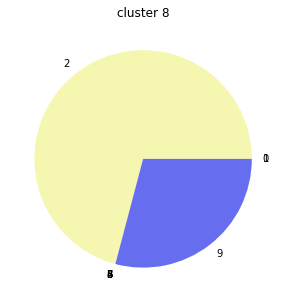

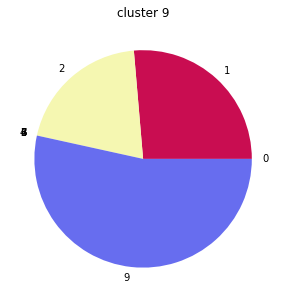

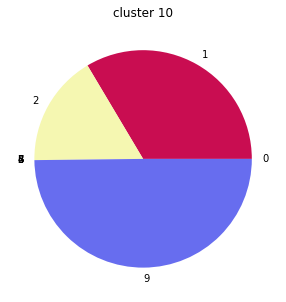

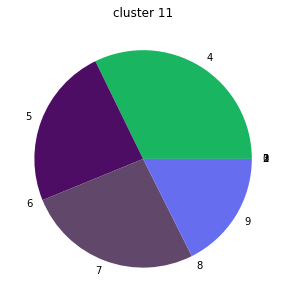

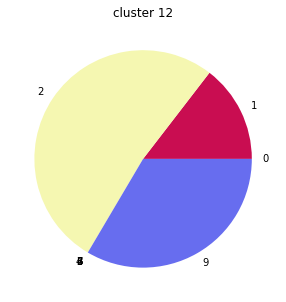

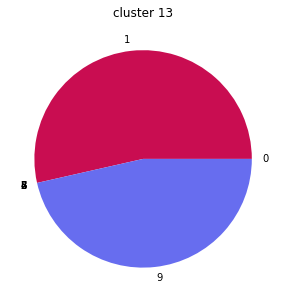

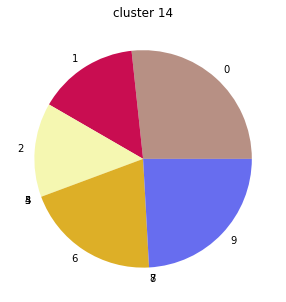

In [16]:
#pie chart for each component
color_set = random_colors(n_components+2)
x = np.arange(n_components)
for k in range(n_cluster_knn + 1):
    plt.figure(figsize = (5,5))
    plt.pie(filt_dict[k].flatten(), labels = x, colors = color_set)
    plt.title("cluster " + str(k))
    plt.show()

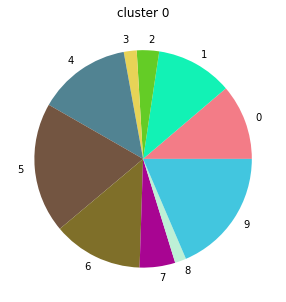

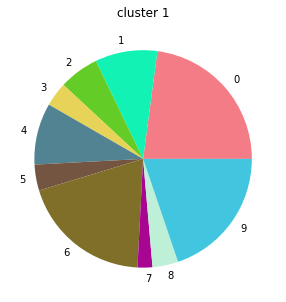

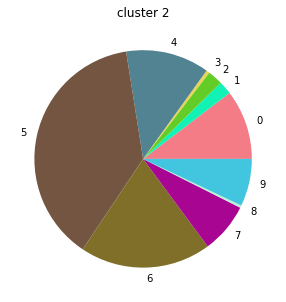

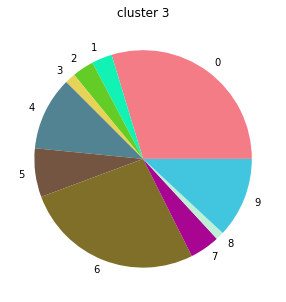

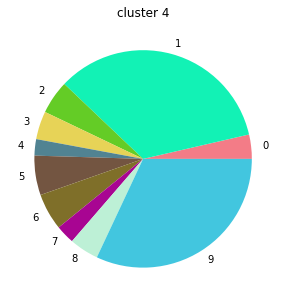

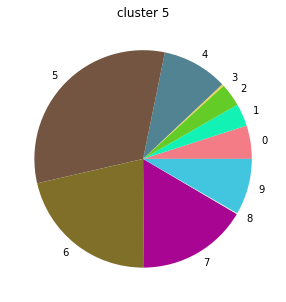

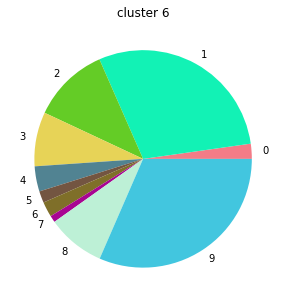

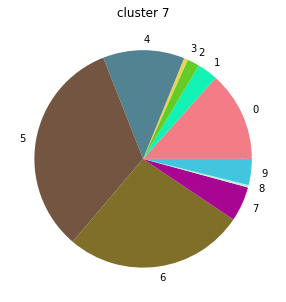

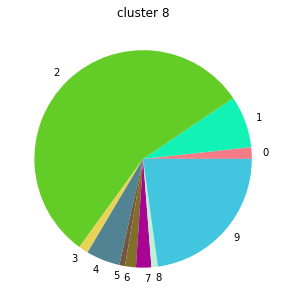

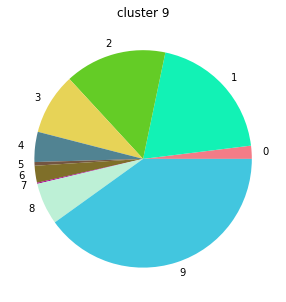

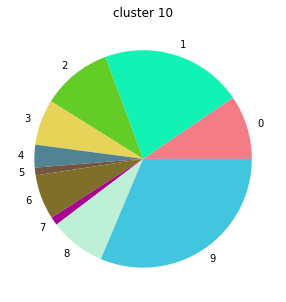

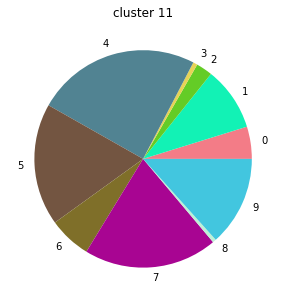

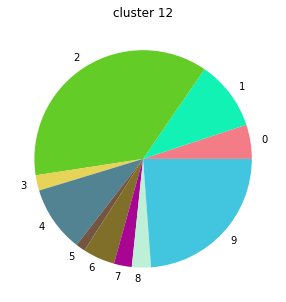

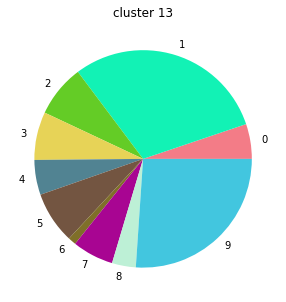

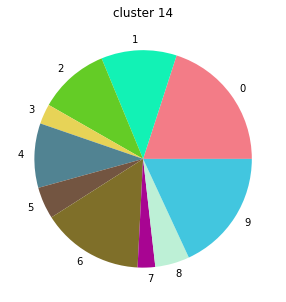

In [140]:
x = np.arange(n_components)
for k in range(n_cluster_knn + 1):
    plt.figure(figsize = (5,5))
    plt.pie(avg_dict[k].flatten(), labels = x, colors = color_set)
    plt.title("cluster " + str(k))
    plt.show()

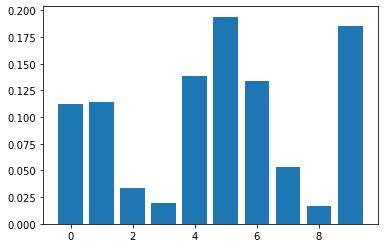

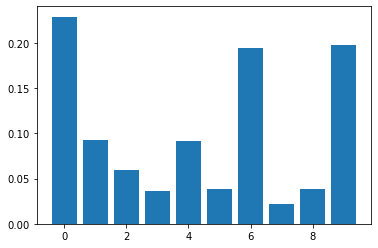

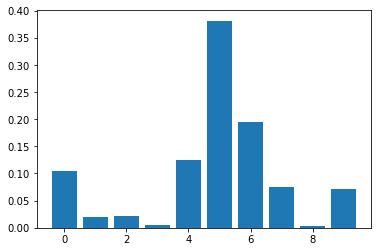

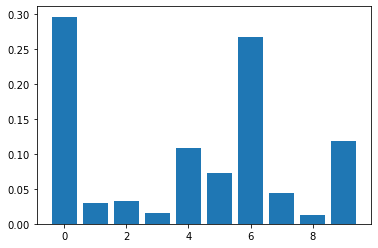

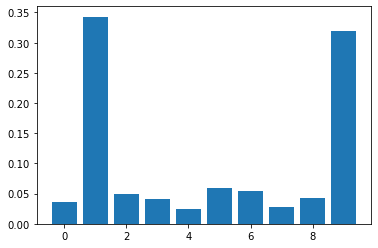

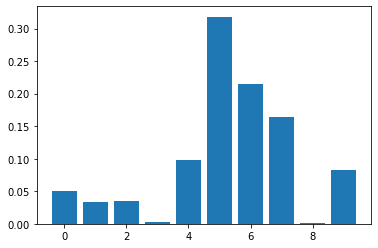

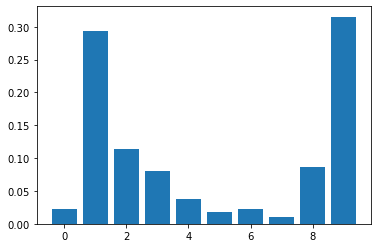

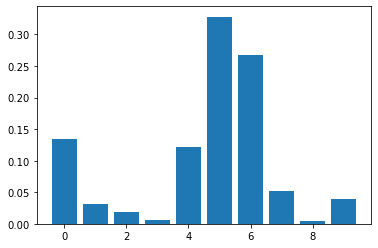

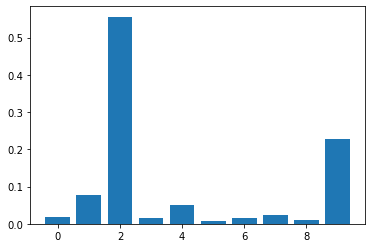

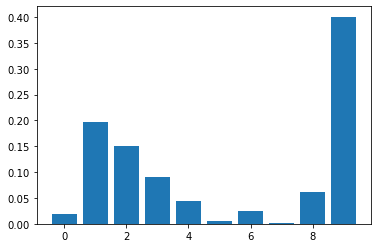

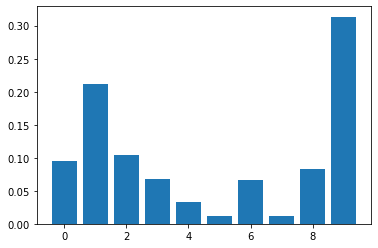

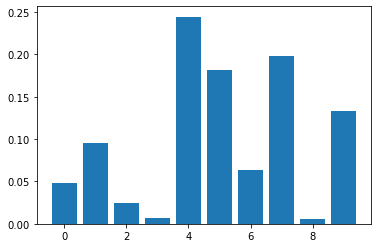

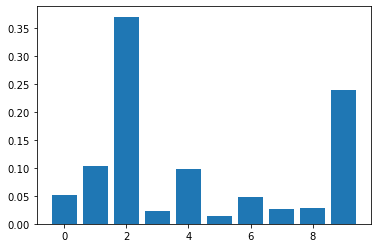

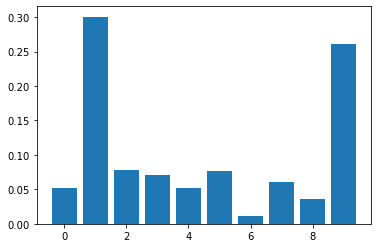

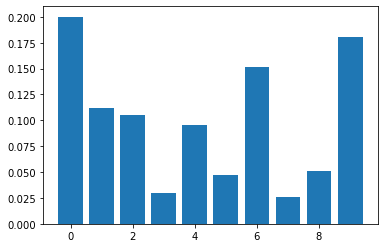

In [141]:
#histogram chart for UNFILTERED components showing ratio of each component for each cluster
x = np.arange(n_components)
for k in range(n_cluster_knn + 1):
    plt.figure()
    plt.bar(x,avg_dict[k].flatten())
    plt.show()


# spot-level analysis

In [ ]:
#in case need to NORMALIZE
# W_norm = np.zeros((1,n_components, len(df2)))
# for spot in range(len(df2)):
#     norm = np.sum(W10[:,:,spot])
#     W_norm[:,:,spot] = W10[:,:,spot]/norm

In [18]:
def not_mixed(W_norm, threshold):
    array = []
    n_components = W_norm.shape[1]
    for i in range(W_norm.shape[2]):
        spot_test = np.array(W_norm[:,:,i]).flatten()
        for j in range(n_components):
            if spot_test[j] >= threshold:
                array.append(i)
    return array


# def two_mixed(W_norm):
#     array = []
#     n_components = W_norm.shape[1]
#     for i in range(W_norm.shape[2]):
#         spot_test = np.array(W_norm[:,:,i]).flatten()
#         for j in range(n_components):
#             if spot_test[j] >= 0.5:
#                 array.append(i)
#     return array

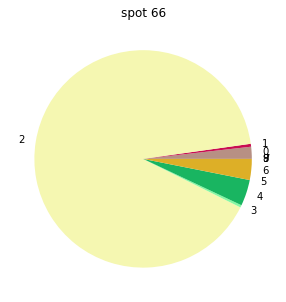

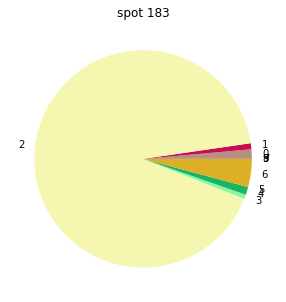

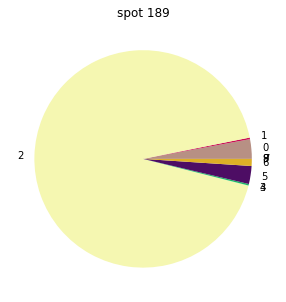

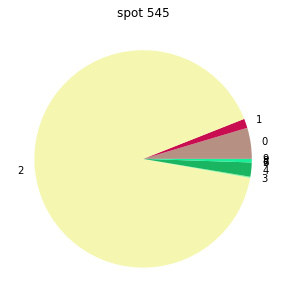

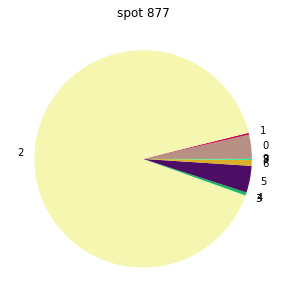

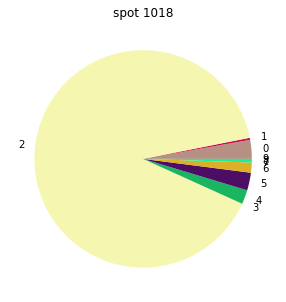

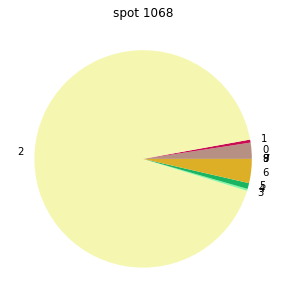

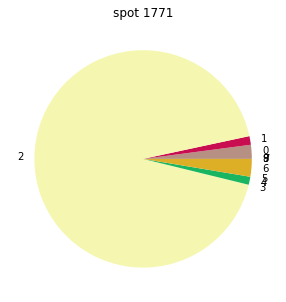

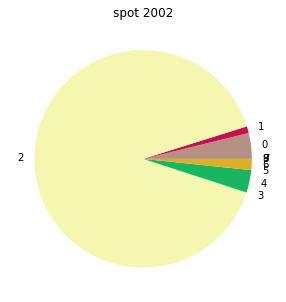

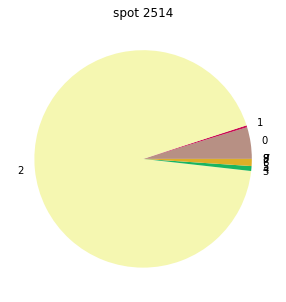

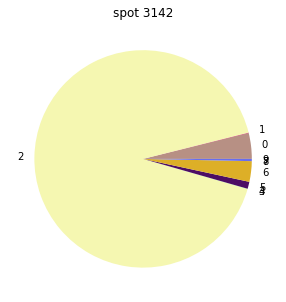

In [88]:
non_mixed = not_mixed(W_norm,0.9)
x = np.arange(n_components)
i=0
for k in non_mixed:
    plt.figure(figsize = (5,5))
    plt.pie(W_norm[:,:,k].flatten(), labels = x, colors = color_set)
    plt.title("spot " + str(k))
    plt.show()
    if i ==10:
        break
    i+=1

In [92]:
W_reshape = W_norm.reshape(n_components,W_norm.shape[2])

In [93]:
W_df = pd.DataFrame(W_reshape, columns = df2.index)
W_df = W_df.transpose() #now it should be component by spot

In [49]:
cell_dict = OrderedDict()
cell_dict['myeloid'] = ['CD14','CD68','APOE','CD81','CD9','CD163','CD1C','FLT3']
cell_dict['NK'] = ['ITGAM','CD27','NCAM1','CXCR4','CCR7','GNLY','FCGR3A','NKG7']
cell_dict['macrophage'] = ['CD68','MRC1','MSR1','NRP1','CD82','CD4','FCGR3A','CD14','CD163','CD86','CD81','C5AR1','HLA-DRB1']
cell_dict['b_cell'] = ['CD19','CD40LG','IGHD','EBF1','TCF3','CD1C','CD19','MS4A1','CR2','CD27']
cell_dict['hsc'] = ['CD34']
cell_dict['t_cell'] = ['CD3D','CD3E']
cell_dict['prolif'] = ['MKI67']

# myeloid = c('FLT3','CD9','CD14','APOE'),
#  NKs = c('NKG7','GNLY'),
#  macrophages = c('MRC1', 'CD86'),
#  Bcells = c('CD19','CD79B'),
#  M1_Macrophage_Polarization = c('IL6', 'CD86', 'CXCL10', 'CD86', 'CCL5'),
#  M2_Macrophage_Polarization = c('IL10', 'CSF1R', 'CCL4', 'CCL17', 'CTSA', 'CTSB', 'TGFB3', 'MMP19', 'WNT7B', 'TNFSF12'),
#  endothelial_cells = c('PECAM1', 'CDH5'),
#  Tcells = c('CD3E','CD3D'),
#  Tregs = c('FOXP3')


celltype_counts = OrderedDict()

for key in cell_dict:
    gene_set = cell_dict[key]
    counts = np.zeros(len(log_norm_df)) #array that will hold average cell count for that gene set for all cells 
    for gene in gene_set:
        gene_array = log_norm_df.loc[:,gene]
        counts = np.add(counts,gene_array)
    counts = np.divide(counts,len(gene_set))
    celltype_counts[key] = counts

In [20]:
celltype_counts['NK']

A_0      -0.421580
A_1      -1.104033
A_2       0.228459
A_3      -1.845248
A_4      -1.655775
            ...   
B_3197   -1.185792
B_3198   -1.997304
B_3199   -0.402773
B_3200   -1.091046
B_3201   -0.989373
Length: 5708, dtype: float64

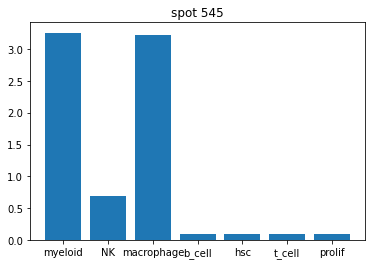

In [90]:
### look at spot 13 and 31 
SPOT = 545
spot_13 = OrderedDict()
spot_df = log_norm_df.iloc[SPOT]
for key in cell_dict:
    gene_set = cell_dict[key]
    counts = 0 #array that will hold average cell count for that gene set for all cells 
    for gene in gene_set:
        gene_array = spot_df[gene]
        counts += gene_array
    counts = np.divide(counts,len(gene_set))
    spot_13[key] = counts
    
x = np.array(list(cell_dict.keys()))
plt.bar(x,np.exp(np.array(list(spot_13.values())))) #no longer in log 
plt.title("spot " + str(SPOT))
plt.show()

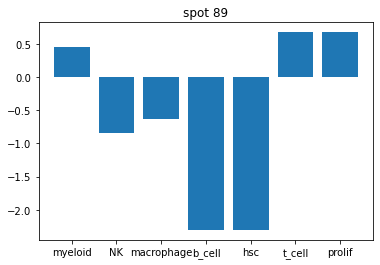

In [81]:
### look at spot 13 and 31 
SPOT = 89
spot_13 = OrderedDict()
spot_df = log_norm_df.iloc[SPOT]
for key in cell_dict:
    gene_set = cell_dict[key]
    counts = 0 #array that will hold average cell count for that gene set for all cells 
    for gene in gene_set:
        gene_array = spot_df[gene]
        counts += gene_array
    counts = np.divide(counts,len(gene_set))
    spot_13[key] = counts
    
x = np.array(list(cell_dict.keys()))
plt.bar(x,np.array(list(spot_13.values())))
plt.title("spot " + str(SPOT))
plt.show()

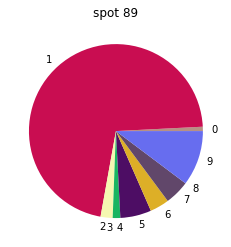

In [75]:
x = np.arange(n_components)
plt.pie(W_norm[:,:,SPOT].flatten(), labels = x, colors = color_set)
plt.title("spot " + str(SPOT))
plt.show()

In [94]:
W_df

,0,1,2,3,4,5,6,7,8,9
A_0,0.257322,0.047773,0.123834,0.005362,0.141966,0.000000,0.201546,0.011160,0.000449,0.210588
A_1,0.069114,0.108957,0.003368,0.028850,0.120829,0.273962,0.087475,0.053562,0.012551,0.241331
A_2,0.008071,0.184129,0.120035,0.344365,0.004998,0.000000,0.010728,0.007820,0.046645,0.273208
A_3,0.149910,0.071636,0.032934,0.005285,0.139223,0.311610,0.158776,0.000000,0.052552,0.078074
A_4,0.128887,0.051775,0.025611,0.015495,0.097459,0.395386,0.195756,0.039289,0.000957,0.049386
...,...,...,...,...,...,...,...,...,...,...
B_3197,0.128736,0.307466,0.000973,0.003226,0.132720,0.161306,0.089886,0.072546,0.069069,0.034070
B_3198,0.119162,0.014863,0.015335,0.001585,0.123454,0.400870,0.147350,0.075181,0.000162,0.102038
B_3199,0.033598,0.189619,0.031854,0.008687,0.036633,0.069386,0.046885,0.000000,0.045412,0.537925
B_3200,0.158128,0.004613,0.059758,0.002540,0.022265,0.105415,0.093331,0.114987,0.003016,0.435947


In [97]:
tsne_output = TSNE(n_components=2, perplexity = 30).fit_transform(W_df)
tsne_nmf = pd.DataFrame(tsne_output, index=W_df.index, columns=['x', 'y'])

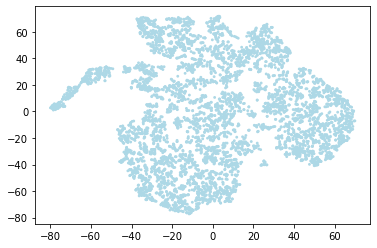

In [98]:
plt.scatter(tsne_nmf['x'], tsne_nmf['y'], s=8,edgecolors='none', c='lightblue')
plt.show()

In [9]:
# umap_data = umap.UMAP()
# results = umap_data.fit_transform(W_df);
# umap_ = pd.DataFrame(results, index=W_df.index, columns=['x', 'y'])
# plt.scatter(results[:, 0],results[:, 1],s=3,edgecolors='none', cmap=matplotlib.cm.Spectral_r, c=np.log10(ms+0.1))
# plt.colorbar()

##### CLUSTERING W PROPORTIONS

In [95]:
knn = kneighbors_graph(W_df,n_neighbors = 30, mode='distance', metric = 'manhattan', include_self = True)
communities, graph, Q = phenograph.cluster(knn)

Using neighbor information from provided graph, rather than computing neighbors directly
Jaccard graph constructed in 0.8150668144226074 seconds
Wrote graph to binary file in 0.4969961643218994 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.809921
After 2 runs, maximum modularity is Q = 0.811329
After 3 runs, maximum modularity is Q = 0.812379
Louvain completed 23 runs in 2.838759660720825 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 4.9033308029174805 seconds


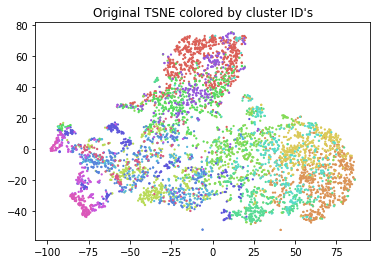

In [102]:
ID =["ID"]
n_cluster_knn = np.amax(communities)
cluster_ID_knn = pd.DataFrame(communities, index = pca_projections.index, columns = ID)
color_set = pd.Series(list(sns.color_palette('hls', n_cluster_knn)))
num_in_cluster = np.zeros(n_cluster_knn)
i=0
for cluster in range(n_cluster_knn):
    bool_array = cluster_ID_knn.ID == cluster
    cells = tsne.index[bool_array]
    num_in_cluster[i] = len(cells)
    plt.scatter(tsne.loc[cells, 'x'], tsne.loc[cells, 'y'],
        s=5, edgecolors='none', color=color_set[cluster])
    i +=1
plt.title("Original TSNE colored by cluster ID's")
plt.show()

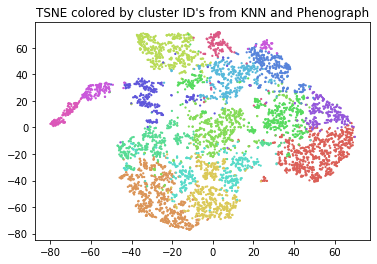

In [99]:
ID =["ID"]
n_cluster_knn = np.amax(communities)
cluster_ID_knn = pd.DataFrame(communities, index = W_df.index, columns = ID)
# color_set = pd.Series(list(sns.color_palette('hls', n_cluster_knn)))
num_in_cluster = np.zeros(n_cluster_knn)
i=0
for cluster in range(n_cluster_knn):
    bool_array = cluster_ID_knn.ID == cluster
    cells = tsne_nmf.index[bool_array]
    num_in_cluster[i] = len(cells)
    plt.scatter(tsne_nmf.loc[cells, 'x'], tsne_nmf.loc[cells, 'y'],
        s=5, edgecolors='none', color=color_set[cluster])
    i +=1
plt.title("TSNE colored by cluster ID's from KNN and Phenograph")
plt.show()

In [ ]:
ID =["ID"]
n_cluster_knn = np.amax(communities)
cluster_ID_knn = pd.DataFrame(communities, index = W_df.index, columns = ID)
# color_set = pd.Series(list(sns.color_palette('hls', n_cluster_knn)))
num_in_cluster = np.zeros(n_cluster_knn)
i=0
for cluster in range(n_cluster_knn):
    bool_array = cluster_ID_knn.ID == cluster
    cells = tsne_nmf.index[bool_array]
    num_in_cluster[i] = len(cells)
    plt.scatter(tsne_nmf.loc[cells, 'x'], tsne_nmf.loc[cells, 'y'],
        s=5, edgecolors='none', color=color_set[cluster])
    i +=1
plt.title("TSNE colored by cluster ID's from KNN and Phenograph")
plt.show()

In [ ]:
# #get list of top N genes for each cluster IGNORE
# def deg(df2, N, n_cluster_knn):
#     array = []
#     cluster_df = pd.DataFrame(df2)
#     cluster_df["cluster_number"] = df["cluster"]
#     for cluster in range(n_cluster_knn + 1):
#         clust = cluster_df[cluster_df["cluster_number"] == cluster]
#         n_genes = clust.shape[1]
#         p_corr = np.zeros(n_genes)
#         for i in range(n_genes):
#             gene_expression = clust.iloc[:,i]
#             p_corr[i] = stats.pearsonr(gene_expression, data[:,1])[0]
#         col_names=[ "pearson"]
#         pearson = pd.DataFrame(p_corr, index = counts_transpose.columns, columns=col_names)
#         pearson_high = pearson.sort_values(by = ['pearson'], ascending= False)
#         gene_set = np.array(pearson_high.index[0:N])
        
#     return array



# n_genes = len(counts_transpose.columns)
# p_corr = np.zeros(n_genes)
# for i in range(n_genes):
#     gene_expression = counts_transpose.iloc[:,i]
#     p_corr[i] = stats.pearsonr(gene_expression, data[:,1])[0]
# col_names=[ "pearson"]
# pearson = pd.DataFrame(p_corr, index = counts_transpose.columns, columns=col_names)

# pearson_high = pearson.sort_values(by = ['pearson'], ascending= False)
# gene_set = np.array(pearson_high.index[0:10])
# gene = np.reshape(gene_set, (len(gene_set),1))